# 1. Ingesta de librerías

In [336]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer


# 2. Extracción

In [337]:
df = pd.read_csv('timeseries_haul_loading_data.csv')

# 3. Analisis previo de calidad

In [338]:
#Vista previa de los primeros 3 datos
df.head(3)

,truck,loader,ton,n_shovel,truck_total_cycle,loader_total_cycle,distance_empty,distance_full,date
0,CAEX56,PH06,299.682208,3.0,2158.0,315.0,4975.0,5191.0,2023-01-01
1,CAEX64,PH48,316.673117,3.0,1737.0,353.0,5152.0,4960.0,2023-01-01
2,CAEX41,PH06,340.529701,3.0,2210.0,388.0,5042.0,4859.0,2023-01-01


In [339]:
#Para ver la información de los valores nulos, tipos de datos y cantidad total de datos que cuenta la base de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395680 entries, 0 to 395679
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   truck               395680 non-null  object 
 1   loader              395680 non-null  object 
 2   ton                 395680 non-null  float64
 3   n_shovel            395680 non-null  float64
 4   truck_total_cycle   395680 non-null  float64
 5   loader_total_cycle  395680 non-null  float64
 6   distance_empty      395680 non-null  float64
 7   distance_full       395680 non-null  float64
 8   date                395680 non-null  object 
dtypes: float64(6), object(3)
memory usage: 27.2+ MB


In [340]:
#Para obtener una descripción estadística de las columnas numéricas
df.describe()

,ton,n_shovel,truck_total_cycle,loader_total_cycle,distance_empty,distance_full
count,395680.000000,395680.000000,395680.000000,395680.000000,395680.000000,395680.000000
mean,318.007490,3.316556,2284.313481,305.073340,6161.241612,5782.712235
std,18.124753,0.558689,856.620246,116.657122,2569.465489,2355.404982
min,0.000000,3.000000,23.000000,0.000000,512.000000,504.000000
25%,305.666647,3.000000,1633.000000,217.000000,3931.000000,3754.000000
50%,317.758250,3.000000,2134.000000,303.000000,6009.000000,5412.000000
75%,330.125978,4.000000,2945.000000,390.000000,8059.000000,7798.000000
max,384.927167,15.000000,15812.000000,11692.000000,15783.000000,15691.000000


Definición de datos incongruentes por columna:

- Ton: Se presenta que el dato mínimo es de 0 toneladas, lo cual no es correcto ya que es una base de datos de acarreo de material.

- n_shovel: En esta columna se puede apreciar que el promedio de paladas es de 3.31, pero al observar el valor máximo encontrado es de 15, lo cual se evidencia que existe algún error

- truck_total_cycle: podemos apreciar que en promedio el tiempo de ciclo de los camiones es de 2284, pero se tiene un valor máximo de 15812 segundos lo cual es casi 7 veces lo que se tiene en promedio

- loader total_cycle: al igual que en los casos anteriores, se tiene un promedio de 305.07  pero, existe un valor con un máximo de 11692 segundos y a su vezun valor mínimo de 0

- distance_empty: se tiene que em promedio son 6161.24 segundos pero hay un valor que es de 15783 lo cual no calza con este promedio.

- distance_full: se tieneun promedio de 2355.40 pero como valor máximo se tiene un dato de 15691

En conclusión se limpiará en base a cada problematica d elas columnas para tener una buena calidad de datos


In [341]:
#Podemos ver una descripción de las columnas categoricas
df.describe(include=['O'])

,truck,loader,date
count,395680,395680,395680
unique,47,4,509
top,CAEX66,PH58,2023-12-26
freq,18531,125098,1368


Con la descripción de las valores categoricas podemos ver que en total se tienen 47 Camiones y 4 cargadores (Palas). como también, los que se repiten con una mayor frecuencia en la base de datos

In [342]:
#Verificamos el tamaño del dataset
df.shape

(395680, 9)

# 4. Transformación

## 4.1. Visualización y Limpieza de Outliers

### 4.1.1.  Limpieza columna ton

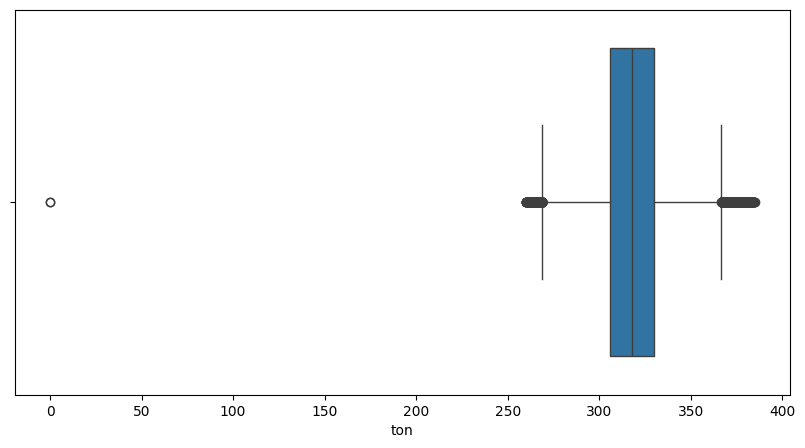

In [343]:
#Graficamos un boxplot para observar los outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['ton']) 
plt.show()

En este caso podemos ver que hay datos bastantes datos átipicos sobre todo algunos datos que se encuentra en 0 de tonelaje. 

por ende, se utilizará el rango intercuartílico para disminuir estos valores.

In [344]:
#N° de outliers usando rango IQR
outliers = {}

Q1 = np.percentile(df['ton'], 25)
Q3 = np.percentile(df['ton'], 75)
IQR = Q3 - Q1
lim_inferior = Q1 - 1.5 * IQR
lim_superior = Q3 + 1.5 * IQR
outliers['ton'] = int((df['ton'] > lim_superior).sum() + (df['ton'] < lim_inferior).sum())

print(outliers)

{'ton': 2382}


In [345]:
#Vemos las filas que son consideradas outliers dado los tonelajes ordenadas de menor a mayor
ubicacion_outliers_paladas = (df['ton'] < lim_inferior) | (df['ton'] > lim_superior)
df[ubicacion_outliers_paladas].sort_values('ton')

,truck,loader,ton,n_shovel,truck_total_cycle,loader_total_cycle,distance_empty,distance_full,date
325362,CAEX60,PH55,0.000000,3.0,2049.0,52.0,4574.0,4430.0,2024-03-10
325469,CAEX23,PH55,0.000000,3.0,1973.0,228.0,4463.0,4384.0,2024-03-10
185057,CAEX66,PH48,260.038945,3.0,3041.0,359.0,7644.0,8338.0,2023-10-05
172672,CAEX81,PH58,260.081832,4.0,2665.0,429.0,7921.0,7704.0,2023-09-16
103180,CAEX56,PH48,260.095310,3.0,2816.0,333.0,10208.0,8370.0,2023-05-29
...,...,...,...,...,...,...,...,...,...
216645,CAEX52,PH58,384.366848,4.0,1470.0,238.0,9802.0,1099.0,2023-11-12
21237,CAEX41,PH55,384.638768,5.0,2457.0,223.0,4963.0,4246.0,2023-02-02
341291,CAEX93,PH58,384.690754,6.0,1896.0,540.0,3719.0,5980.0,2024-03-26
12611,CAEX58,PH06,384.822104,5.0,1823.0,633.0,5156.0,3916.0,2023-01-19


In [346]:
#reordenamos nuestro daataset sin los outliers anteriores
df_sin_out_ton = (df['ton'] >= lim_inferior) & (df['ton'] <= lim_superior)
df_ton = df[df_sin_out_ton].reset_index(drop=True)
df_ton

,truck,loader,ton,n_shovel,truck_total_cycle,loader_total_cycle,distance_empty,distance_full,date
0,CAEX56,PH06,299.682208,3.0,2158.0,315.0,4975.0,5191.0,2023-01-01
1,CAEX64,PH48,316.673117,3.0,1737.0,353.0,5152.0,4960.0,2023-01-01
2,CAEX41,PH06,340.529701,3.0,2210.0,388.0,5042.0,4859.0,2023-01-01
3,CAEX41,PH06,292.835476,3.0,2073.0,260.0,5005.0,4869.0,2023-01-01
4,CAEX71,PH06,337.056639,3.0,2346.0,148.0,5614.0,5289.0,2023-01-01
...,...,...,...,...,...,...,...,...,...
393293,CAEX22,PH58,320.327729,3.0,1976.0,320.0,1671.0,4884.0,2024-05-24
393294,CAEX30,PH48,274.369483,4.0,1826.0,275.0,4021.0,5000.0,2024-05-24
393295,CAEX37,PH58,319.958519,3.0,1834.0,268.0,4630.0,4882.0,2024-05-24
393296,CAEX08,PH55,296.690314,3.0,1729.0,318.0,3925.0,3941.0,2024-05-24


Revisamos por  el boxplot y su estadistica descriptiva con los datos actualizados

In [347]:
df_ton['ton'].describe()

count    393298.000000
mean        317.896667
std          17.688370
min         268.987963
25%         305.694247
50%         317.710688
75%         329.973666
max         366.808994
Name: ton, dtype: float64

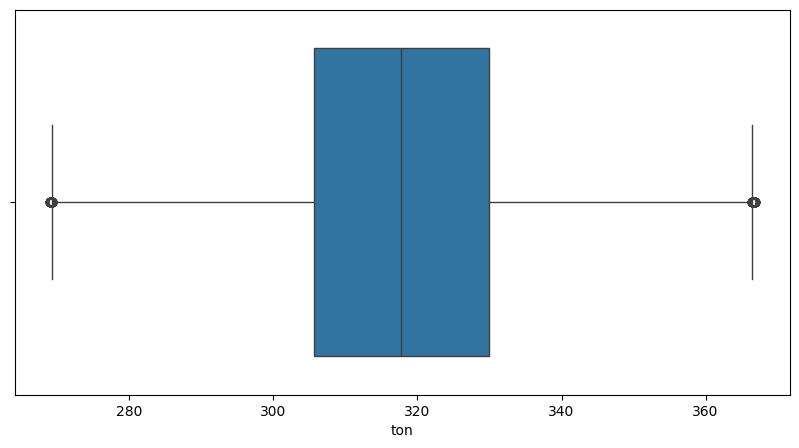

In [348]:
#Graficamos un boxplot para observar los outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_ton['ton']) 
plt.show()

Con esto, podemos ver que el mínimo ha cambiado y  solo se presentan valores átipicos en sus extremos

----------------

### 4.1.2. Limpieza Columna n_shovel

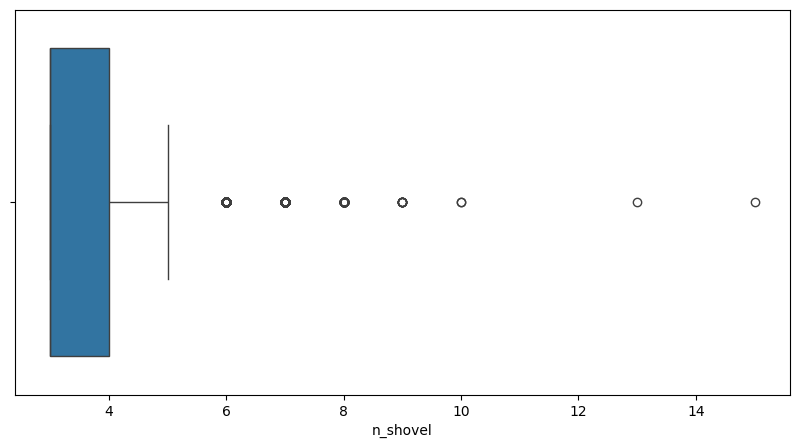

In [349]:
#Graficamos un boxplot para observar los outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_ton['n_shovel']) 
plt.show()

En este caso podemos ver que existen varios datos átipicos fuera del extremo superior que se presenta en este grafico por lo que se procederá a utilizárá el rango intercuartílico para disminuir estos numeros lejanos a lo normal.

In [350]:
#N° de outliers usando rango IQR
outliers_paladas = {}

Q1_pala = np.percentile(df_ton['n_shovel'], 25)
Q3_pala = np.percentile(df_ton['n_shovel'], 75)
IQR_pala = Q3_pala - Q1_pala
lim_inferior_pala = Q1_pala - 1.5 * IQR_pala
lim_superior_pala = Q3_pala + 1.5 * IQR_pala
outliers_paladas['n_shovel'] = int((df_ton['n_shovel'] > lim_superior_pala).sum() + (df_ton['n_shovel'] < lim_inferior_pala).sum())

print(outliers_paladas)

{'n_shovel': 2378}


In [351]:
#Vemos las filas que son consideradas outliers dado las paladas ordenadas de menor a mayor
ubicacion_outliers_paladas = (df_ton['n_shovel'] < lim_inferior_pala) | (df_ton['n_shovel'] > lim_superior_pala)
df_ton[ubicacion_outliers_paladas].sort_values('n_shovel')

,truck,loader,ton,n_shovel,truck_total_cycle,loader_total_cycle,distance_empty,distance_full,date
620,CAEX93,PH55,307.756957,6.0,3016.0,382.0,4060.0,7854.0,2023-01-02
393041,CAEX41,PH55,341.438053,6.0,2242.0,423.0,4132.0,4099.0,2024-05-24
392668,CAEX98,PH55,350.547260,6.0,2480.0,470.0,4076.0,3902.0,2024-05-24
392599,CAEX22,PH55,352.435810,6.0,2041.0,440.0,4134.0,4045.0,2024-05-24
391786,CAEX24,PH48,308.235793,6.0,2738.0,427.0,9752.0,9752.0,2024-05-22
...,...,...,...,...,...,...,...,...,...
134242,CAEX21,PH55,346.862248,9.0,2638.0,659.0,6049.0,4492.0,2023-07-14
113018,CAEX74,PH48,344.151458,10.0,3455.0,184.0,8310.0,8180.0,2023-06-13
50254,CAEX42,PH48,291.378209,10.0,3457.0,694.0,6824.0,6830.0,2023-03-17
121410,CAEX60,PH06,334.025514,13.0,1940.0,115.0,6720.0,3422.0,2023-06-25


In [352]:
#reordenamos nuestro daataset sin los outliers anteriores
df_sin_out_palas = (df_ton['n_shovel'] >= lim_inferior_pala) & (df_ton['n_shovel'] <= lim_superior_pala)
df_pala = df_ton[df_sin_out_palas].reset_index(drop=True)
df_pala

,truck,loader,ton,n_shovel,truck_total_cycle,loader_total_cycle,distance_empty,distance_full,date
0,CAEX56,PH06,299.682208,3.0,2158.0,315.0,4975.0,5191.0,2023-01-01
1,CAEX64,PH48,316.673117,3.0,1737.0,353.0,5152.0,4960.0,2023-01-01
2,CAEX41,PH06,340.529701,3.0,2210.0,388.0,5042.0,4859.0,2023-01-01
3,CAEX41,PH06,292.835476,3.0,2073.0,260.0,5005.0,4869.0,2023-01-01
4,CAEX71,PH06,337.056639,3.0,2346.0,148.0,5614.0,5289.0,2023-01-01
...,...,...,...,...,...,...,...,...,...
390915,CAEX22,PH58,320.327729,3.0,1976.0,320.0,1671.0,4884.0,2024-05-24
390916,CAEX30,PH48,274.369483,4.0,1826.0,275.0,4021.0,5000.0,2024-05-24
390917,CAEX37,PH58,319.958519,3.0,1834.0,268.0,4630.0,4882.0,2024-05-24
390918,CAEX08,PH55,296.690314,3.0,1729.0,318.0,3925.0,3941.0,2024-05-24


Revisamos el boxplot y su estadistica descriptiva con los datos actualizados

In [353]:
df_pala['n_shovel'].describe()

count    390920.000000
mean          3.297184
std           0.508985
min           3.000000
25%           3.000000
50%           3.000000
75%           4.000000
max           5.000000
Name: n_shovel, dtype: float64

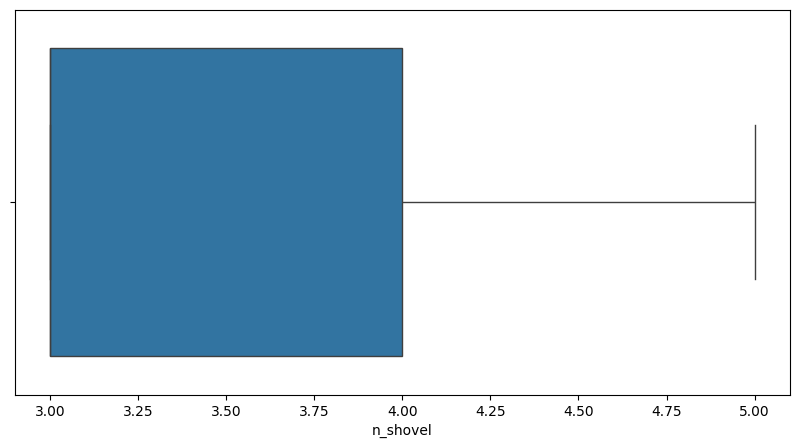

In [354]:
#Graficamos un boxplot para observar los outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_pala['n_shovel']) 
plt.show()

Con esto apreciamos que el mínimo de paladas son 3 y el máximo de 5 y, en nuestro gráfico de caja no presentamos valores fuera del extremo.

-------------

### 4.1.3. Limpieza columna truck_total_cycle

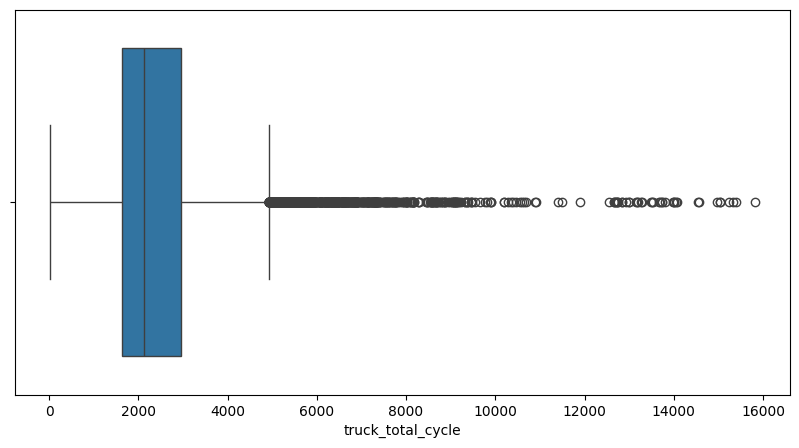

In [355]:
#Graficamos un boxplot para observar los outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_pala['truck_total_cycle']) 
plt.show()

en este caso podemos apreciar que existen muchos valores átípico en el extremo superior por lo que utilizarémos el rango intercuartílico con el fin de disminuir la mayoria de estos

In [356]:
#N° de outliers usando rango IQR
outliers_tcycle = {}

Q1_tcycle = np.percentile(df_pala['truck_total_cycle'], 25)
Q3_tcycle = np.percentile(df_pala['truck_total_cycle'], 75)
IQR_tcycle = Q3_tcycle - Q1_tcycle
lim_inferior_tcycle = Q1_tcycle - 1.5 * IQR_tcycle
lim_superior_tcycle = Q3_tcycle + 1.5 * IQR_tcycle
outliers_tcycle['truck_total_cycle'] = int((df_pala['truck_total_cycle'] > lim_superior_tcycle).sum() + (df_pala['truck_total_cycle'] < lim_inferior_tcycle).sum())

print(outliers_tcycle)

{'truck_total_cycle': 1127}


In [357]:
#Vemos las filas que son consideradas outliers dado el tiempo de ciclo del camión ordenadas de menor a mayor
ubicacion_outliers_tcycle = (df_pala['truck_total_cycle'] < lim_inferior_tcycle) | (df_pala['truck_total_cycle'] > lim_superior_tcycle)
df_pala[ubicacion_outliers_tcycle].sort_values('truck_total_cycle')

,truck,loader,ton,n_shovel,truck_total_cycle,loader_total_cycle,distance_empty,distance_full,date
202634,CAEX42,PH58,311.758925,3.0,4923.0,219.0,13738.0,13741.0,2023-10-30
203965,CAEX37,PH48,332.285246,3.0,4923.0,240.0,13821.0,7970.0,2023-10-31
252277,CAEX31,PH58,321.731694,3.0,4923.0,379.0,9106.0,9305.0,2023-12-23
389186,CAEX96,PH48,359.658618,3.0,4923.0,154.0,9182.0,9269.0,2024-05-22
276772,CAEX55,PH06,347.537088,3.0,4924.0,445.0,10167.0,4276.0,2024-01-17
...,...,...,...,...,...,...,...,...,...
109978,CAEX34,PH48,309.863978,3.0,15041.0,390.0,12414.0,7919.0,2023-06-10
109878,CAEX21,PH48,272.869079,3.0,15232.0,409.0,12445.0,7756.0,2023-06-10
110236,CAEX94,PH06,298.228803,3.0,15320.0,383.0,14436.0,5557.0,2023-06-10
106256,CAEX93,PH58,322.482213,3.0,15386.0,424.0,11802.0,8064.0,2023-06-04


In [358]:
#reordenamos nuestro daataset sin los outliers anteriores
df_sin_out_tcycle = (df_pala['truck_total_cycle'] >= lim_inferior_tcycle) & (df_pala['truck_total_cycle'] <= lim_superior_tcycle)
df_tcycle = df_pala[df_sin_out_tcycle].reset_index(drop=True)
df_tcycle

,truck,loader,ton,n_shovel,truck_total_cycle,loader_total_cycle,distance_empty,distance_full,date
0,CAEX56,PH06,299.682208,3.0,2158.0,315.0,4975.0,5191.0,2023-01-01
1,CAEX64,PH48,316.673117,3.0,1737.0,353.0,5152.0,4960.0,2023-01-01
2,CAEX41,PH06,340.529701,3.0,2210.0,388.0,5042.0,4859.0,2023-01-01
3,CAEX41,PH06,292.835476,3.0,2073.0,260.0,5005.0,4869.0,2023-01-01
4,CAEX71,PH06,337.056639,3.0,2346.0,148.0,5614.0,5289.0,2023-01-01
...,...,...,...,...,...,...,...,...,...
389788,CAEX22,PH58,320.327729,3.0,1976.0,320.0,1671.0,4884.0,2024-05-24
389789,CAEX30,PH48,274.369483,4.0,1826.0,275.0,4021.0,5000.0,2024-05-24
389790,CAEX37,PH58,319.958519,3.0,1834.0,268.0,4630.0,4882.0,2024-05-24
389791,CAEX08,PH55,296.690314,3.0,1729.0,318.0,3925.0,3941.0,2024-05-24


Revisamos  el boxplot y su estadistica descriptiva con los datos actualizados

In [359]:
df_tcycle['truck_total_cycle'].describe()

count    389793.000000
mean       2274.078988
std         825.779020
min          23.000000
25%        1631.000000
50%        2132.000000
75%        2941.000000
max        4922.000000
Name: truck_total_cycle, dtype: float64

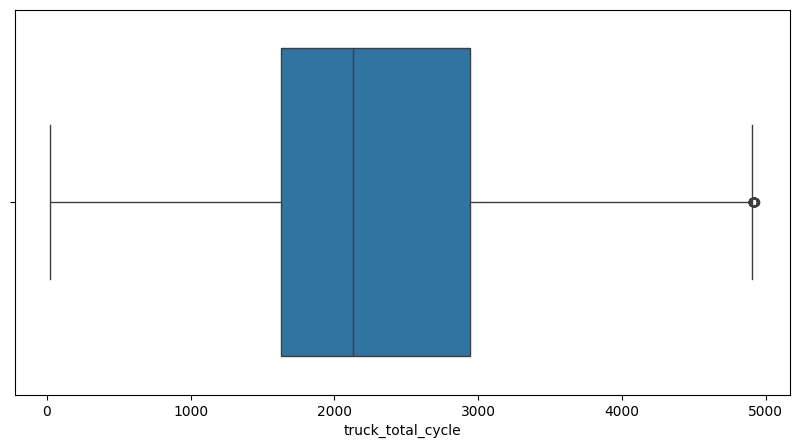

In [360]:
#Graficamos un boxplot para observar los outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_tcycle['truck_total_cycle']) 
plt.show()

a partir de la estadistica descriptiva se puede ver que tenemos el valor mínimo como 0 y varios datos que están bajo los 1000 hasta los 0 segundos, lo cual nos generaría problemas a la hora de analizar. por esto, se presenta un histograma para ver el comportamiento en general de los datos de esta columna

<Axes: xlabel='truck_total_cycle', ylabel='Count'>

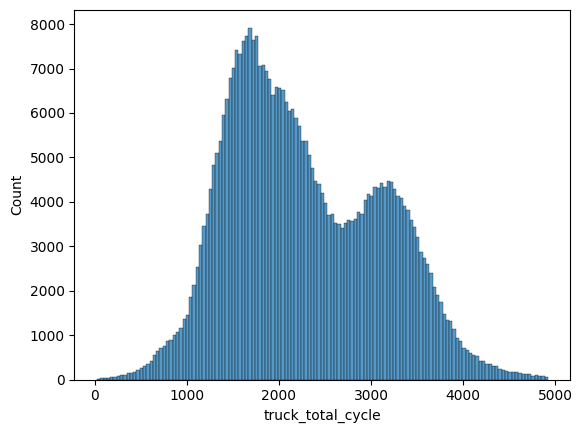

In [361]:
sns.histplot(x=df_tcycle['truck_total_cycle'])

se puede ver que hay una cola con datos bajos los cuales los reemplazaremos por valores aleatorios entre el percentil 1 y la mediana de esta columna para no afectar ls distribución de los datos ya que anteriormente ya se eliminaron los datos átipicos/extremos

In [362]:
# Calcular los percen
p1_tcycle = df_tcycle['truck_total_cycle'].quantile(0.01)

# Mostrar los resultados
print(f"Percentil 1 (P1): {p1_tcycle}")

#cantidad de valores bajo el p1
print( f"Cantidad de valores bajo el percentil 1:", int((df_tcycle['truck_total_cycle'] < p1_tcycle).sum()))

Percentil 1 (P1): 711.0
Cantidad de valores bajo el percentil 1: 3888


Ahora, teniendo el percentil 1 que corresponde a 711 segundos (11.85 minutos) por ende, las filas que posean valores de tiempo de ciclo de transporte menor a esto, serán reemplazados por valores aleatorios entre el percentil 1 y la mediana con el fin de no perder los datos y afectar nuestro análisis ya que se eliminarian 3888 datos.

In [363]:
#Calculamos la mediana para esta columna
mediana_tcycle = df_tcycle['truck_total_cycle'].median()

# Reemplazar valores por debajo del percentil 1
df_tcycle['truck_total_cycle'] = np.where(df_tcycle['truck_total_cycle'] < p1_tcycle, 
                       np.random.uniform(p1_tcycle, mediana_tcycle, size=(len(df_tcycle['truck_total_cycle'] < p1_tcycle))), 
                       df_tcycle['truck_total_cycle'])

ahora, volvemos a verificar si notenemos el mismo problema con valores bajos luego de haber realizado el reemplazo

In [364]:
df_tcycle['truck_total_cycle'].describe()

count    389793.000000
mean       2282.826773
std         812.696739
min         711.000000
25%        1637.000000
50%        2132.000000
75%        2941.000000
max        4922.000000
Name: truck_total_cycle, dtype: float64

<Axes: xlabel='truck_total_cycle', ylabel='Count'>

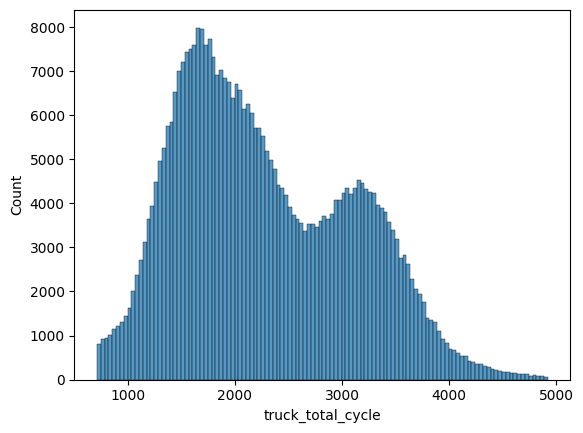

In [365]:
sns.histplot(x=df_tcycle['truck_total_cycle'])

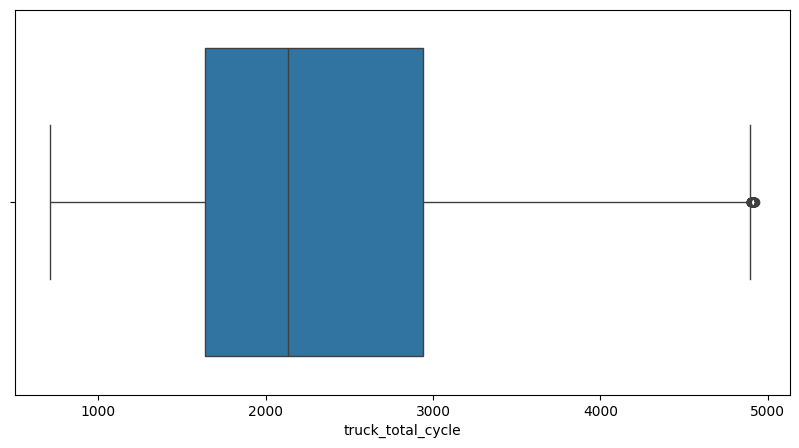

In [366]:
#Graficamos un boxplot para observar los outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_tcycle['truck_total_cycle']) 
plt.show()

Ahora, al ver la estadistica descriptiva tenemos que el valor mínimo es de 711 segundos, el histograma no perdio su la forma que tenía antes de reemplazar los valores y el boxplot presenta solo valores atipicos en el extremo superior del gráfico pero sin contar con valores cercanos al 0.

------------------------------------

### 4.1.4. Limpieza columna loader_total_cycle

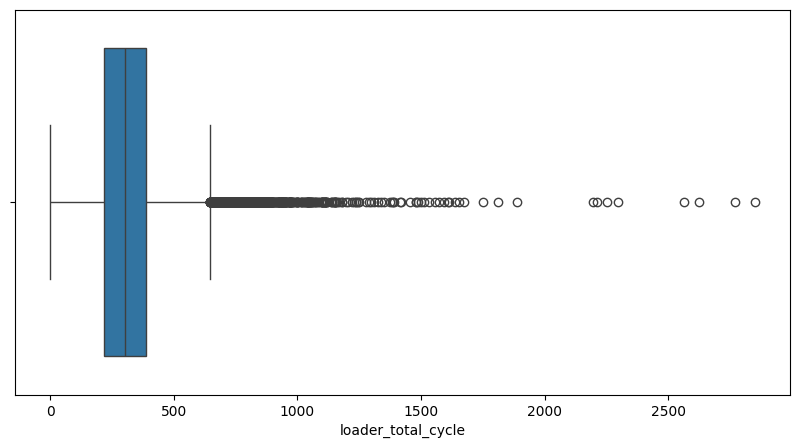

In [367]:
#Graficamos un boxplot para observar los outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_tcycle['loader_total_cycle']) 
plt.show()

podemos ver que hay varios datos los cuales son considerados átipicos por lo que procedemos a utilizar el rango intercuantilico.

In [368]:
#N° de outliers usando rango IQR
outliers_lcycle = {}

Q1_lcycle = np.percentile(df_tcycle['loader_total_cycle'], 25)
Q3_lcycle = np.percentile(df_tcycle['loader_total_cycle'], 75)
IQR_lcycle = Q3_lcycle - Q1_lcycle
lim_inferior_lcycle = Q1_lcycle - 1.5 * IQR_lcycle
lim_superior_lcycle = Q3_lcycle + 1.5 * IQR_lcycle
outliers_lcycle['loader_total_cycle'] = int((df_tcycle['loader_total_cycle'] > lim_superior_lcycle).sum() + (df_tcycle['loader_total_cycle'] < lim_inferior_lcycle).sum())

print(outliers_lcycle)

{'loader_total_cycle': 1178}


In [369]:
#reordenamos nuestro daataset sin los outliers anteriores
df_sin_out_lcycle = (df_tcycle['loader_total_cycle'] >= lim_inferior_lcycle) & (df_tcycle['loader_total_cycle'] <= lim_superior_lcycle)
df_lcycle = df_tcycle[df_sin_out_lcycle].reset_index(drop=True) 
df_lcycle

,truck,loader,ton,n_shovel,truck_total_cycle,loader_total_cycle,distance_empty,distance_full,date
0,CAEX56,PH06,299.682208,3.0,2158.0,315.0,4975.0,5191.0,2023-01-01
1,CAEX64,PH48,316.673117,3.0,1737.0,353.0,5152.0,4960.0,2023-01-01
2,CAEX41,PH06,340.529701,3.0,2210.0,388.0,5042.0,4859.0,2023-01-01
3,CAEX41,PH06,292.835476,3.0,2073.0,260.0,5005.0,4869.0,2023-01-01
4,CAEX71,PH06,337.056639,3.0,2346.0,148.0,5614.0,5289.0,2023-01-01
...,...,...,...,...,...,...,...,...,...
388610,CAEX22,PH58,320.327729,3.0,1976.0,320.0,1671.0,4884.0,2024-05-24
388611,CAEX30,PH48,274.369483,4.0,1826.0,275.0,4021.0,5000.0,2024-05-24
388612,CAEX37,PH58,319.958519,3.0,1834.0,268.0,4630.0,4882.0,2024-05-24
388613,CAEX08,PH55,296.690314,3.0,1729.0,318.0,3925.0,3941.0,2024-05-24


Ahora revisamos la estadistica descriptiva y el boxplot actualizado

In [370]:
df_lcycle['loader_total_cycle'].describe()

count    388615.000000
mean        302.494026
std         110.024436
min           0.000000
25%         216.000000
50%         302.000000
75%         388.000000
max         647.000000
Name: loader_total_cycle, dtype: float64

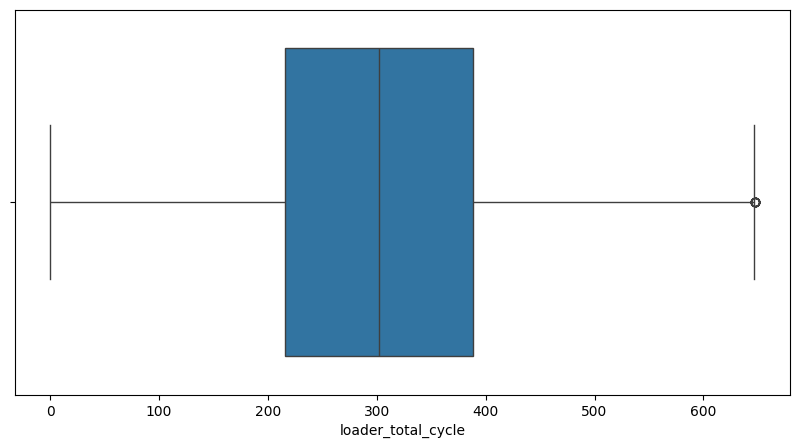

In [371]:
#Graficamos un boxplot para observar los outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_lcycle['loader_total_cycle']) 
plt.show()

con los datos actualizados, se observa que se tiene un valor mínimo de 0 y del gráfico tenemos varios datos bajolos 100 segundos los cuales algunos pueden no representar la realidad del carguio. Para esto, se presenta un gráfico de histograma y poder analizar de una mejor manera este caso

<Axes: xlabel='loader_total_cycle', ylabel='Count'>

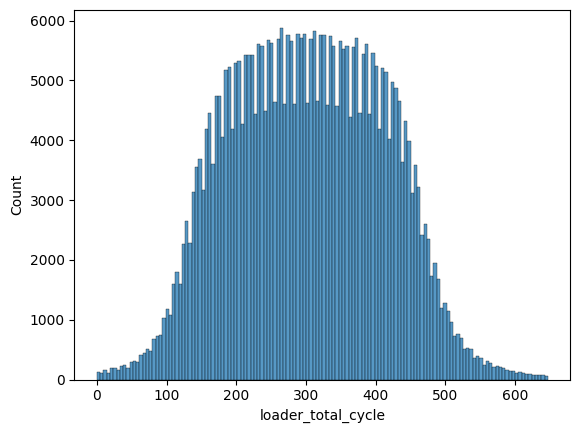

In [372]:
sns.histplot(x=df_lcycle['loader_total_cycle'])

del histrograma podemos ver que se tiene una distribución normal lo cual podría ser cierto, si es que los datos no estuviesen tan cerca del 0. Por ende, se utilizará el percentil 1 y la mediana con el fin de reemplazar valores que no sean bajos.

In [373]:
# Calcular los percen
p1_lcycle = df_lcycle['loader_total_cycle'].quantile(0.01)

# Mostrar los resultados
print(f"Percentil 1 (P1): {p1_lcycle}")

#cantidad de valores bajo el p1
print( f"Cantidad de bajos bajo el percentil 1:", int((df_lcycle['loader_total_cycle'] < p1_lcycle).sum()))

Percentil 1 (P1): 75.0
Cantidad de bajos bajo el percentil 1: 3847


Ahora, teniendo el percentil 1 que corresponde a 77 segundos (1.6833... minutos) haremos que las filas que posean valores de tiempo de ciclo de carga menor a esto, serán reemplazados por valores aleatorios entre el percentil 1 y la mediana con el fin de no perder los datos y afectar nuestro análisis ya que se eliminarian 3733 datos.

In [374]:
#Calculamos la mediana para esta columna
mediana_lcycle = df_lcycle['loader_total_cycle'].median()

# Reemplazar valores por debajo del percentil 1
df_lcycle['loader_total_cycle'] = np.where(df_lcycle['loader_total_cycle'] < p1_lcycle, 
                       np.random.uniform(p1_lcycle, mediana_lcycle, size=(len(df_lcycle['loader_total_cycle'] < p1_lcycle))), 
                       df_lcycle['loader_total_cycle'])

ahora, volvemos a verificar la estadistica descriptiva, histograma y el grafico de boxplot

In [375]:
df_lcycle['loader_total_cycle'].describe()

count    388615.000000
mean        303.911566
std         107.790206
min          75.000000
25%         218.000000
50%         302.000000
75%         388.000000
max         647.000000
Name: loader_total_cycle, dtype: float64

<Axes: xlabel='loader_total_cycle', ylabel='Count'>

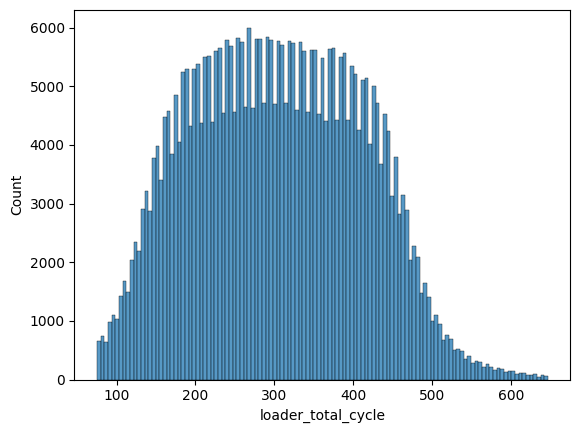

In [376]:
sns.histplot(x=df_lcycle['loader_total_cycle'])

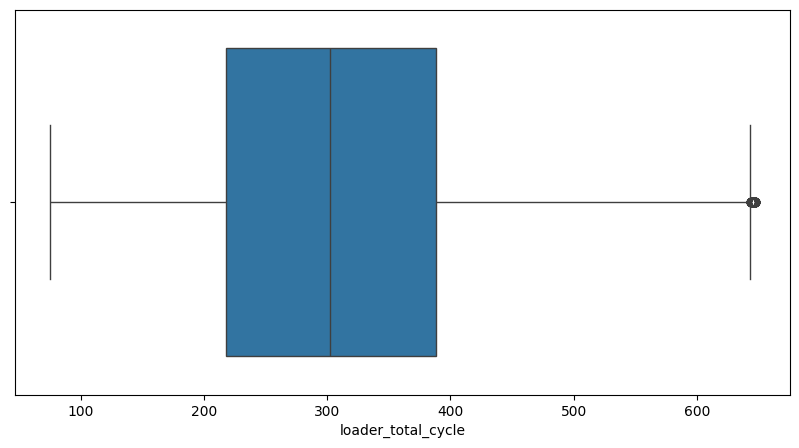

In [377]:
#Graficamos un boxplot para observar los outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_lcycle['loader_total_cycle']) 
plt.show()

apreciamos que el dato mínimo es de 77 segundos, el histograma no se ve afectado por el cambio que se realizó solamente su cola hacia el cero (era, lo que se buscaba) y el boxplot presenta los valores átpicos solamente en su extremo superior, lo cual los utilizarémos para analizar casos muy extremos hacia arriba.

---------------------------------------------------------------------------

### 4.1.5.Limpieza columna distance_empty

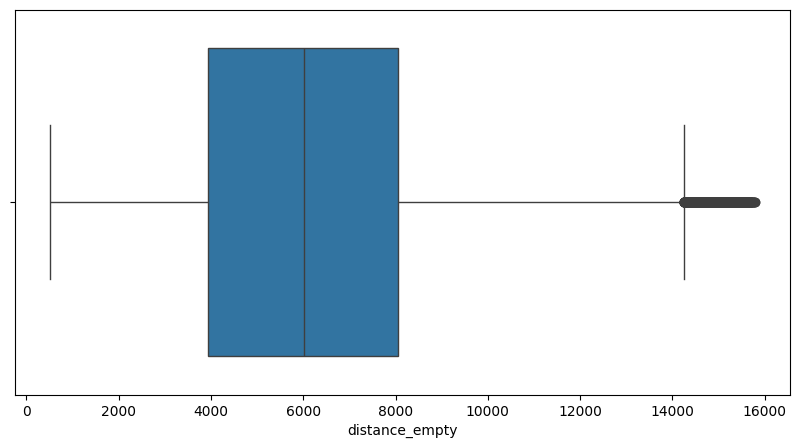

In [378]:
#Graficamos un boxplot para observar los outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_lcycle['distance_empty']) 
plt.show()

Del grafico podemos ver que hay varios datos que están fuera del extremo derecho, por lo que utilizarémos el rango intercuartílico

In [379]:
#N° de outliers usando rango IQR
outliers_dempty = {}

Q1_dempty = np.percentile(df_lcycle['distance_empty'], 25)
Q3_dempty = np.percentile(df_lcycle['distance_empty'], 75)
IQR_dempty = Q3_dempty - Q1_dempty
lim_inferior_dempty = Q1_dempty - 1.5 * IQR_dempty
lim_superior_dempty = Q3_dempty + 1.5 * IQR_dempty
outliers_dempty['distance_empty'] = int((df_lcycle['distance_empty'] > lim_superior_dempty).sum() + (df_lcycle['distance_empty'] < lim_inferior_dempty).sum())

outliers_dempty

{'distance_empty': 1932}

In [380]:
#Vemos las filas que son consideradas outliers dada la distancia recorrida del camión vacío de menor a mayor
ubicacion_outliers_dempty = (df_lcycle['distance_empty'] < lim_inferior_dempty) | (df_lcycle['distance_empty'] > lim_superior_dempty)
df_lcycle[ubicacion_outliers_dempty].sort_values('distance_empty')

,truck,loader,ton,n_shovel,truck_total_cycle,loader_total_cycle,distance_empty,distance_full,date
223949,CAEX85,PH58,319.363233,3.0,2858.0,149.0,14255.0,8886.0,2023-11-25
25892,CAEX23,PH48,345.305491,3.0,2786.0,146.0,14256.0,3770.0,2023-02-11
232073,CAEX44,PH06,349.130717,4.0,2645.0,202.0,14256.0,3113.0,2023-12-03
171911,CAEX25,PH48,338.461599,3.0,3579.0,409.0,14256.0,7944.0,2023-09-20
172171,CAEX13,PH48,319.086429,3.0,3512.0,398.0,14256.0,7737.0,2023-09-20
...,...,...,...,...,...,...,...,...,...
59932,CAEX37,PH58,334.181749,4.0,3074.0,262.0,15758.0,7565.0,2023-03-31
181577,CAEX98,PH58,331.204743,3.0,3108.0,355.0,15768.0,7291.0,2023-10-05
139934,CAEX93,PH48,295.125581,3.0,4440.0,380.0,15771.0,8767.0,2023-07-27
82270,CAEX81,PH48,312.806754,3.0,2423.0,418.0,15782.0,10747.0,2023-05-02


In [381]:
#reordenamos nuestro daataset sin los outliers anteriores
df_sin_out_dempty = (df_lcycle['distance_empty'] >= lim_inferior_dempty) & (df_lcycle['distance_empty'] <= lim_superior_dempty)
df_dempty = df_lcycle[df_sin_out_dempty].reset_index(drop=True) 
df_dempty

,truck,loader,ton,n_shovel,truck_total_cycle,loader_total_cycle,distance_empty,distance_full,date
0,CAEX56,PH06,299.682208,3.0,2158.0,315.0,4975.0,5191.0,2023-01-01
1,CAEX64,PH48,316.673117,3.0,1737.0,353.0,5152.0,4960.0,2023-01-01
2,CAEX41,PH06,340.529701,3.0,2210.0,388.0,5042.0,4859.0,2023-01-01
3,CAEX41,PH06,292.835476,3.0,2073.0,260.0,5005.0,4869.0,2023-01-01
4,CAEX71,PH06,337.056639,3.0,2346.0,148.0,5614.0,5289.0,2023-01-01
...,...,...,...,...,...,...,...,...,...
386678,CAEX22,PH58,320.327729,3.0,1976.0,320.0,1671.0,4884.0,2024-05-24
386679,CAEX30,PH48,274.369483,4.0,1826.0,275.0,4021.0,5000.0,2024-05-24
386680,CAEX37,PH58,319.958519,3.0,1834.0,268.0,4630.0,4882.0,2024-05-24
386681,CAEX08,PH55,296.690314,3.0,1729.0,318.0,3925.0,3941.0,2024-05-24


<Axes: xlabel='distance_empty', ylabel='Count'>

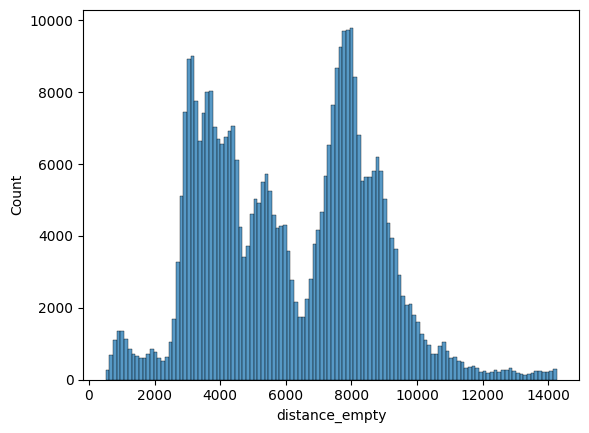

In [382]:
sns.histplot(x=df_dempty['distance_empty'])

revisamos por ultima vez la estadistica descriptiva y el grafico de boxplot para verificar

In [383]:
df_dempty['distance_empty'].describe()

count    386683.000000
mean       6121.544694
std        2497.155294
min         512.000000
25%        3924.000000
50%        5998.000000
75%        8044.000000
max       14254.000000
Name: distance_empty, dtype: float64

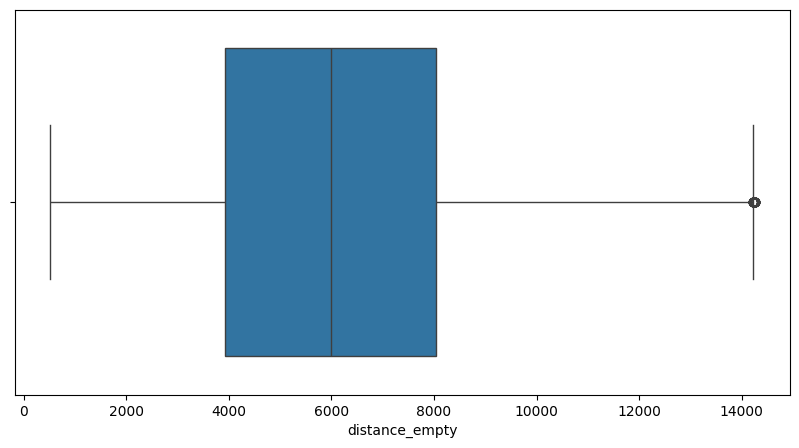

In [384]:
#Graficamos un boxplot para observar los outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_dempty['distance_empty']) 
plt.show()

En este caso podemos ver que la estadistica descriptiva el valor mínimo sigue siendo el mismo pero, el valor máximo disminuyo de aproximadamente 16000 a 14200 aproximadamente al haber eliminado 1932 filas.

Aceptaremos estos valores, considerando que es posible que hayan casos en que las rutas sean bastante más cortas en comparados a otros y casos muy altos donde se pueda ver el efecto de una mala optimización de ruta y/o problemas que se puedan haber generado en el transporte.

### 4.1.6. Limpieza columna distance_full

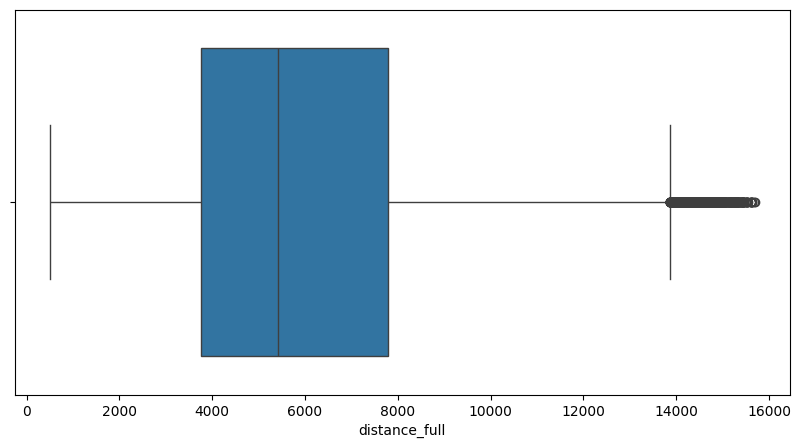

In [385]:
#Graficamos un boxplot para observar los outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_dempty['distance_full']) 
plt.show()

In [386]:
#N° de outliers usando rango IQR
outliers_dfull = {}

Q1_dfull = np.percentile(df_dempty['distance_full'], 25)
Q3_dfull = np.percentile(df_dempty['distance_full'], 75)
IQR_dfull = Q3_dfull - Q1_dfull
lim_inferior_dfull = Q1_dfull - 1.5 * IQR_dfull
lim_superior_dfull = Q3_dfull + 1.5 * IQR_dfull
outliers_dfull['distance_full'] = int((df_dempty['distance_full'] > lim_superior_dfull).sum() + (df_dempty['distance_full'] < lim_inferior_dfull).sum())

outliers_dfull

{'distance_full': 1510}

In [387]:
#Vemos las filas que son consideradas outliers dada la distancia recorrida del camión lleno de menor a mayor
ubicacion_outliers_dfull = (df_dempty['distance_full'] < lim_inferior_dfull) | (df_dempty['distance_full'] > lim_superior_dfull)
df_dempty[ubicacion_outliers_dfull].sort_values('distance_full')

,truck,loader,ton,n_shovel,truck_total_cycle,loader_total_cycle,distance_empty,distance_full,date
202339,CAEX44,PH48,294.766217,3.0,3511.0,467.0,832.0,13862.0,2023-11-02
202146,CAEX07,PH48,316.137486,4.0,4012.0,434.0,6154.0,13863.0,2023-11-02
199756,CAEX31,PH58,318.685679,3.0,4849.0,374.0,13624.0,13863.0,2023-10-30
205097,CAEX93,PH48,328.253394,3.0,3167.0,419.0,6365.0,13863.0,2023-11-05
194554,CAEX73,PH58,282.360251,3.0,3277.0,251.0,1007.0,13864.0,2023-10-23
...,...,...,...,...,...,...,...,...,...
198388,CAEX81,PH58,324.417279,4.0,4543.0,409.0,8207.0,15623.0,2023-10-28
198798,CAEX87,PH58,330.738098,4.0,4391.0,345.0,7963.0,15627.0,2023-10-28
79607,CAEX22,PH48,354.095141,4.0,2048.0,469.0,11857.0,15637.0,2023-04-29
198886,CAEX60,PH58,334.263291,3.0,2352.0,299.0,8105.0,15680.0,2023-10-28


In [388]:
#reordenamos nuestro daataset sin los outliers anteriores
df_sin_out_dfull = (df_dempty['distance_full'] >= lim_inferior_dfull) & (df_dempty['distance_full'] <= lim_superior_dfull)
df_dfull = df_dempty[df_sin_out_dfull].reset_index(drop=True) 
df_dfull

,truck,loader,ton,n_shovel,truck_total_cycle,loader_total_cycle,distance_empty,distance_full,date
0,CAEX56,PH06,299.682208,3.0,2158.0,315.0,4975.0,5191.0,2023-01-01
1,CAEX64,PH48,316.673117,3.0,1737.0,353.0,5152.0,4960.0,2023-01-01
2,CAEX41,PH06,340.529701,3.0,2210.0,388.0,5042.0,4859.0,2023-01-01
3,CAEX41,PH06,292.835476,3.0,2073.0,260.0,5005.0,4869.0,2023-01-01
4,CAEX71,PH06,337.056639,3.0,2346.0,148.0,5614.0,5289.0,2023-01-01
...,...,...,...,...,...,...,...,...,...
385168,CAEX22,PH58,320.327729,3.0,1976.0,320.0,1671.0,4884.0,2024-05-24
385169,CAEX30,PH48,274.369483,4.0,1826.0,275.0,4021.0,5000.0,2024-05-24
385170,CAEX37,PH58,319.958519,3.0,1834.0,268.0,4630.0,4882.0,2024-05-24
385171,CAEX08,PH55,296.690314,3.0,1729.0,318.0,3925.0,3941.0,2024-05-24


Ahora, analizamos la estadistica descriptiva y el boxplot actualizado

In [389]:
df_dfull['distance_full'].describe()

count    385173.000000
mean       5742.353184
std        2283.780978
min         504.000000
25%        3749.000000
50%        5398.000000
75%        7780.000000
max       13860.000000
Name: distance_full, dtype: float64

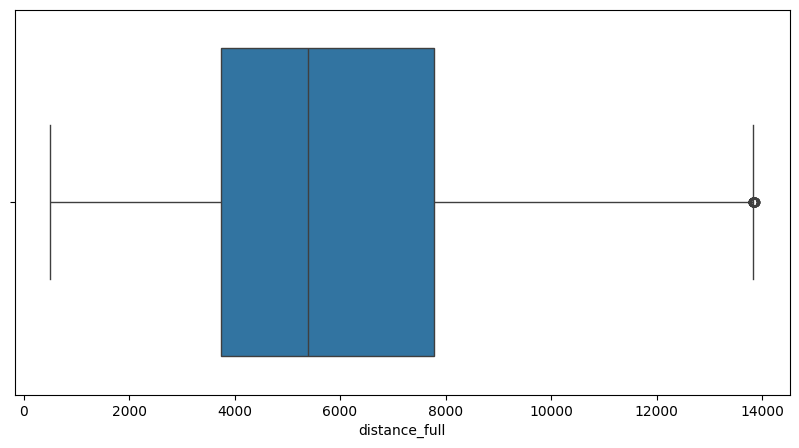

In [390]:
#Graficamos un boxplot para observar los outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_dfull['distance_full']) 
plt.show()

De esto, podemos ver el valor mínimo sigue siendo 504 pero el máximo paso de 15690 a 13860 metros, pero nuestro boxplot no presenta los valores átpicios que se tenían en un principio, solo algunos datos en el extremo superior.

Aceptaremos estos valores, considerando que es posible que hayan casos en que las rutas sean bastante más cortas en comparados a otros y casos muy altos donde se pueda ver el efecto de una mala optimización de ruta y/o problemas que se puedan haber generado en el transporte.

## 4.2. Transformación de datos

In [391]:
df_dfull.head(3)

,truck,loader,ton,n_shovel,truck_total_cycle,loader_total_cycle,distance_empty,distance_full,date
0,CAEX56,PH06,299.682208,3.0,2158.0,315.0,4975.0,5191.0,2023-01-01
1,CAEX64,PH48,316.673117,3.0,1737.0,353.0,5152.0,4960.0,2023-01-01
2,CAEX41,PH06,340.529701,3.0,2210.0,388.0,5042.0,4859.0,2023-01-01


In [392]:
df_final = df_dfull.copy()

In [393]:
df_final.head(3)

,truck,loader,ton,n_shovel,truck_total_cycle,loader_total_cycle,distance_empty,distance_full,date
0,CAEX56,PH06,299.682208,3.0,2158.0,315.0,4975.0,5191.0,2023-01-01
1,CAEX64,PH48,316.673117,3.0,1737.0,353.0,5152.0,4960.0,2023-01-01
2,CAEX41,PH06,340.529701,3.0,2210.0,388.0,5042.0,4859.0,2023-01-01


In [394]:
#Cambiamos los tipos de datos para, numero de paladas (deben ser enteras) y date a tipo fecha
df_final['date'] = pd.to_datetime(df_final['date'])
df_final['n_shovel'] = df_final['n_shovel'].astype(int)
print(df_final['date'].dtypes)
print(df_final['n_shovel'].dtypes)

datetime64[ns]
int64


In [395]:
#Creamos columnas de rendimiento para los camiones y las palas
df_final['ton_paladas'] = df_final['ton']/df_final['n_shovel'] #Toneladas por paladas
df_final['relacion_carga_transporte'] = df_final['truck_total_cycle']/df_final['loader_total_cycle']


In [396]:
df_final.columns

Index(['truck', 'loader', 'ton', 'n_shovel', 'truck_total_cycle',
       'loader_total_cycle', 'distance_empty', 'distance_full', 'date',
       'ton_paladas', 'relacion_carga_transporte'],
      dtype='object')

# 5. Carga de datos

In [397]:
df_final.to_csv('df_final.csv', index = False)

In [398]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385173 entries, 0 to 385172
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   truck                      385173 non-null  object        
 1   loader                     385173 non-null  object        
 2   ton                        385173 non-null  float64       
 3   n_shovel                   385173 non-null  int64         
 4   truck_total_cycle          385173 non-null  float64       
 5   loader_total_cycle         385173 non-null  float64       
 6   distance_empty             385173 non-null  float64       
 7   distance_full              385173 non-null  float64       
 8   date                       385173 non-null  datetime64[ns]
 9   ton_paladas                385173 non-null  float64       
 10  relacion_carga_transporte  385173 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(2